# Press ```Run All``` after changing the ```is_demo``` & ```is_training``` variables below

In [1]:
is_demo = False # Set to True for demonstration, False for actual data collection and training
is_training = True # Set to True for training, False for data collection and demonstration
is_collecting = False

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import serial
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import entropy

In [3]:
# Format: Object-Distance-Height
class_names = ["Coin-10cm-10cm", "Coin-10cm-30cm", "Coin-30cm-10cm", "Coin-30cm-30cm",
               "Eraser-10cm-10cm", "Eraser-10cm-30cm", "Eraser-30cm-10cm", "Eraser-30cm-30cm",
               "Eraser-150cm-10cm"]

col_headers = ["label", "max_amp", "dom_freq", "sqr_sum_e", "decay_rate", "spec_ent", "spec_flat", "weighted_avg_freq"]

## Modify ```# Parameters```

In [ ]:
# Parameters
adc_threshold = 1000  # ADC threshold to start data collection
num_items_to_collect = 40000  # Number of ADC values to collect
class_label = class_names.index("Eraser-10cm-10cm")  # Class label for the current data collection - ignored if is_demo is True
filepath = "data/data_alt_2.csv"  # Name of the CSV file to save the data - ignored if is_demo is True
fs = 10000  # Sampling frequency in Hz

# Data Collection

In [ ]:
if is_collecting:
    # Initialize serial communication
    ser = serial.Serial(port="COM7", baudrate=2000000, timeout=1)  # Configure the serial port
    ser.flush()  # Flush the serial buffer to clear any existing data

    # Function to read ADC value from the serial port
    def read_adc_value():
        """
        Reads a single ADC value from the serial port.
        Returns:
            int: The ADC value if successfully read, otherwise None.
        """
        try:
            if ser.in_waiting > 0:  # Check if data is available in the serial buffer
                line = ser.readline().strip()  # Read and decode the line
                return int(line)  # Convert the line to an integer
        except ValueError:
            # Ignore invalid data that cannot be converted to an integer
            pass
        return None


    # Function to save collected data to a CSV file
    def save_to_csv(data, label, filepath):
        """
        Saves the collected data to a CSV file.
        Args:
            data (list): The list of collected ADC values.
            label (int): The class label for the data.
            filepath (str): The name of the CSV file to save the data.
        """
        # Add the new row to the dataframe
        df.loc[len(df)] = [label] + data
        # Save the dataframe to a CSV file
        df.to_csv(filepath, index=False)


    # Read existing CSV file if it exists, otherwise create a new dataframe
    if not is_demo:
        try:
            df = pd.read_csv(filepath)  # Try to read the existing CSV file
        except FileNotFoundError:
            # Create a new dataframe with appropriate columns if the file doesn't exist
            df = pd.DataFrame(columns=["label"] + ["data" + str(i + 1) for i in range(num_items_to_collect)])

    # Data collection process
    data = []  # List to store collected ADC values

    try:
        print("Data collection started...")
        activated = False  # Flag to indicate if the threshold has been crossed

        # Collect data until the required number of items is reached
        while len(data) < num_items_to_collect:
            adc_value = read_adc_value()  # Read an ADC value
            if adc_value is not None:
                if not activated and adc_value > adc_threshold:
                    # Start collecting data only after the threshold is crossed
                    activated = True
                    print("Threshold crossed. Collecting data...")
                if activated and 0 <= adc_value <= 4095:
                    # Append the ADC value to the data list
                    data.append(adc_value)

        print("Data collection completed.")
    except KeyboardInterrupt:
        # Handle manual interruption (Ctrl+C)
        print("Data collection interrupted.")
    except Exception as e:
        # Handle any other exceptions
        print(f"An error occurred: {e}")

    # Save the collected data to a CSV file
    if not is_demo:
        if data:
            min = np.min(data) + 50
            data = [x if x >= min else 0 for x in data] 
            save_to_csv(data, class_label, filepath)  # Save the data with the class label
            print("Data saved to CSV.")
        else:
            print("No data collected.")
    else:
        # For demonstration, just print the collected data
        print("Collected data (for demo)")

    # Close the serial port
    ser.close()
else:
    # Dummy data for training only
    data = [0] * num_items_to_collect

Data collection started...


## Plot the latest collected data

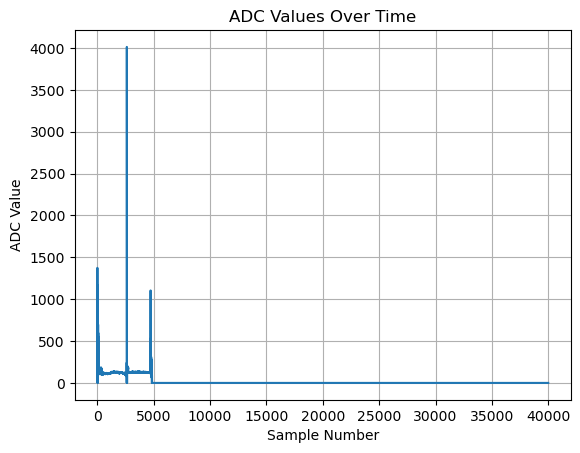

In [ ]:
if is_collecting:    
    plt.plot(range(len(data)), data)  # Plot the ADC values
    plt.xlabel("Sample Number")  # Label for the x-axis
    plt.ylabel("ADC Value")  # Label for the y-axis
    plt.title("ADC Values Over Time")  # Title of the plot
    plt.grid()  # Show grid lines on the plot
    plt.show()  # Display the plot

# Fourier Transform ([Credit](https://www.youtube.com/watch?v=s2K1JfNR7Sc))

## Compute the Fast Fourier Transform (FFT) and plot the Power Spectral Density (PSD) for the latest collected data

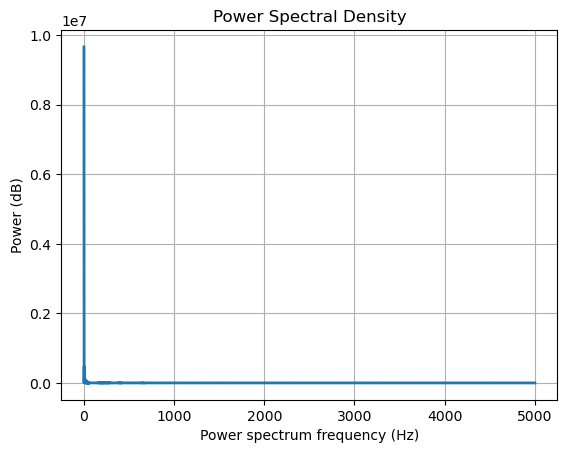

In [ ]:
def compute_psd(data):
    """
    Computes the Power Spectral Density (PSD) of the input signal.
    Args:
        data (array-like): Input time-domain signal.
    Returns:
        array: PSD of the input signal.
    """
    data = data - np.mean(data)  # Remove DC offset
    n = len(data)
    fhat = np.fft.fft(data, n)
    PSD = (fhat * np.conj(fhat)) / n
    return PSD[:n // 2].real, n  # Return only the positive frequencies


if is_collecting:    
    psd, n = compute_psd(data)
    freq = (1 / (n * (1 / fs))) * np.arange(n)  # Frequency bins
    L = np.arange(1, np.floor(n / 2), dtype='int')  # Positive frequencies

    # Plot the Power Spectral Density
    plt.plot(freq[L], psd[L].real, linewidth=2)
    plt.xlabel('Power spectrum frequency (Hz)')
    plt.ylabel('Power (dB)')
    plt.title('Power Spectral Density')
    plt.grid()
    plt.show()

## Fourier transform entire dataset for model training

In [ ]:
if is_training:
    df = pd.read_csv(filepath)  # Read the existing CSV file

    # Create a new DataFrame to store PSD-transformed data
    psd_length = len(df.columns) - 1  # Same number of samples per row (excluding label)
    df_psd = pd.DataFrame(columns=["label"]+ [f"psd{i+1}" for i in range(psd_length // 2)])
 
    for i in range(len(df)):
        label = int(df.iloc[i, 0])  # Extract and ensure label is int
        data = df.iloc[i, 1:].values.astype(float)  # Extract signal values
        psd = compute_psd(data)  # Compute PSD
        df_psd.loc[i] = [label] + list(psd)  # Assign to new DataFrame

    # Convert the label column to integers
    df_psd["label"] = df_psd["label"].astype(int)

    # Save the PSD-transformed data to a new CSV file
    df_psd.to_csv("data_alt_psd.csv", index=False)

# Plotting all the data and labels

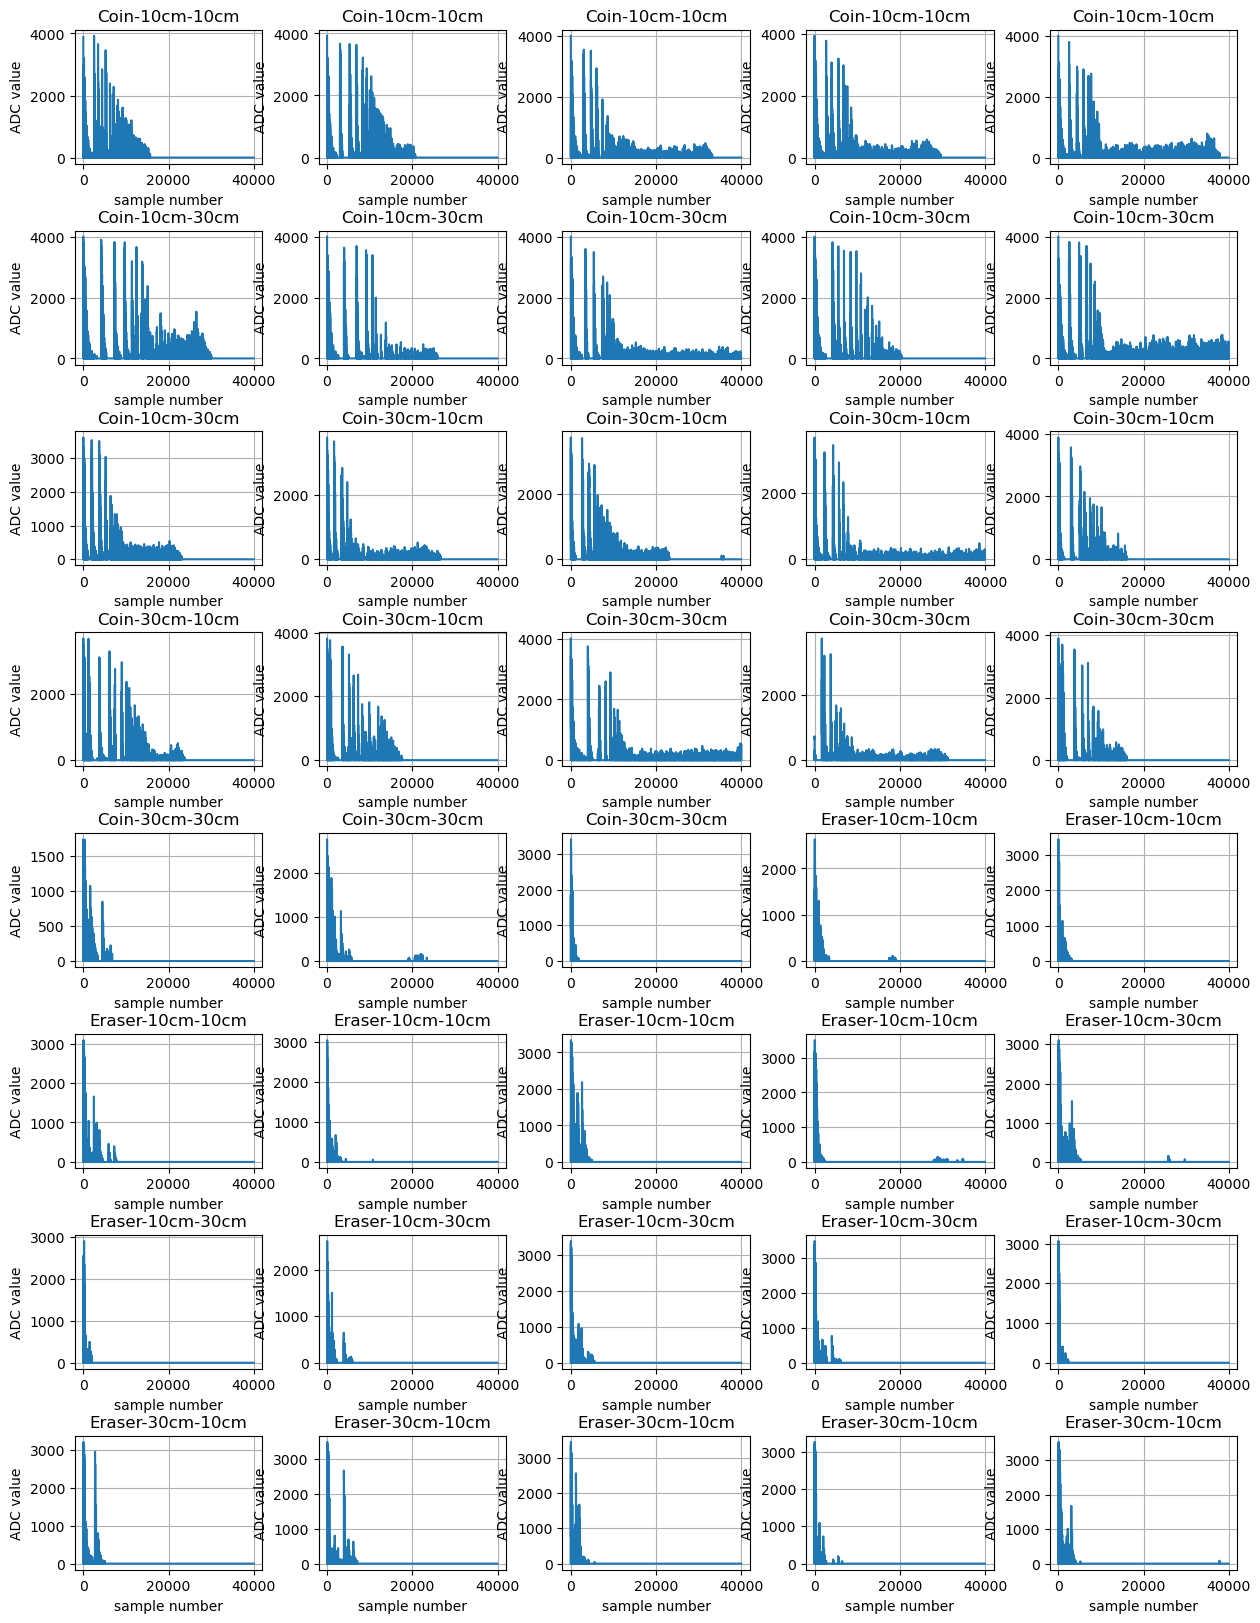

In [46]:
fig, axes = plt.subplots(8, 5, figsize=(15, 20))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axes = axes.flatten()
df = pd.read_csv("data_alt_2.csv").to_numpy()
for i, data in enumerate(df[:]):
    axes[i].plot(range(len(data[1:])), data[1:])
    axes[i].grid()
    axes[i].set_xlabel("sample number")
    axes[i].set_ylabel("ADC value")
    axes[i].set_title(f"{class_names[data[0]]}")


# Extracting features for the entire dataset

In [ ]:
def extract_features(data, data_psd):

    # max amp
    max_amp = max(data)

    # Dominant frequency (PSD max frequency)
    freqs = np.linspace(0, fs, num_items_to_collect // 2) 
    dom_idx = np.argmax(data_psd) 
    dom_freq = freqs[dom_idx] 

    # Energy of drop
    sqr_sum_e = np.sqrt(np.sum(np.pow(data, 2)))

    # Rate of Decay
    peaks = find_peaks(data)
    first_peak = peaks[0][0]
    decay_zone = []
    for j in range(first_peak, len(data)):
        if data[j] == 0:  # If ADC value drops to 0, stop
            decay_zone.append(data[j])
            break
        decay_zone.append(data[j])
    time = np.arange(len(decay_zone))
    del_decay = np.polyfit(time, decay_zone, 1)[0]  # Linear fit for rate of change

    # Spectral Entropy
    psd_normed = (data_psd - np.min(data_psd)) / (np.max(data_psd) - np.min(data_psd))
    spec_ent = entropy(psd_normed)

    # Spectral Flatness
    psd_above_0 = psd[psd > 0] # avoid log 0
    geo_mean = np.exp(np.mean(np.log(psd_above_0)))
    spec_flat = geo_mean / np.mean(psd)

    # Peak frequency band weighted average frequency
    dom_pow = data_psd[dom_idx]
    mask = data_psd >= (0.5 * dom_pow)
    band_freq= freqs[mask]
    band_pow = data_psd[mask]
    weighted_avg_freq = np.sum(band_freq * band_pow) / np.sum(band_pow)

    features = [max_amp, dom_freq, sqr_sum_e, del_decay, spec_ent, spec_flat, weighted_avg_freq]

    return features

if is_training:
    df = pd.read_csv("data_alt_2.csv")
    df_features = pd.DataFrame(columns=col_headers)

    for i in range(len(df)):
        label = int(df.iloc[i, 0])  # Extract and ensure label is int
        data = df.iloc[i, 1:].values.astype(float)  # Extract signal values
        psd = df_psd.iloc[i, 1:].values.astype(float)  # Extract psd values
        features = extract_features(data, psd)  # Compute PSD
        df_features.loc[i] = [label] + list(features)  # Assign to new DataFrame

    # Convert the label column to integers
    df_features["label"] = df_features["label"].astype(int)

    # Save the PSD-transformed data to a new CSV file
    # filepath_features = filepath.replace("data", "data_features")
    df_features.to_csv("data_alt_features.csv", index=False)
    

# Classifying data to a label based on feature thresholds

In [ ]:
data_np = np.array(data)

data_np_offset = data_np - (np.min(data_np)*2)

min_adc_threshold = 200
material_span_threshold = 10e3
coin_bounce_adc_threshold = 2000
eraser_height_adc_threshold = 3100

coin_h10_spec_flat_threshold = 0.1
coin_h30_spec_flat_threshold = 0.125
eraser_h10_spec_ent_threshold = 6.65
eraser_h30_spec_ent_threshold = 6.85

# material-distance-height
material = 0
distance = 0
height = 0

for idx in range(len(data_np_offset)-1, 0, -1):
    if data_np_offset[idx] > min_adc_threshold:
        last_adc_idx = idx
        break

# Material
if last_adc_idx < material_span_threshold:
    material = 1

# Height
if material:    # Height for eraser
    if data_np.max() >= eraser_height_adc_threshold:
        height = 1

else:   # Height for coin
    coin_bounce_higher_than_threshold_idxs = np.where(data_np > coin_bounce_adc_threshold, 1, 0)
    for i, val in enumerate(coin_bounce_higher_than_threshold_idxs):
        if i < 1000:
            continue    # Skip
        if val:
            break

    adc_peak_dist = i
    if adc_peak_dist >= 2750:
        height = 1

# Distance
_, _, _, _, spectral_entropy, spectral_flatness, _ = extract_features(data, psd)

if material: # Distance for eraser
    if height:  # Height is 30cm
        if spectral_entropy < eraser_h30_spec_ent_threshold:
            distance = 1

    else:       # Height is 10 cm
        if spectral_entropy >= eraser_h10_spec_ent_threshold:
            distance = 1

else:   # Distance for coin
    if height:  # Height is 30cm
        if spectral_flatness < coin_h30_spec_flat_threshold:
            distance = 1

    else:       # Height is 10 cm
        if spectral_flatness < coin_h10_spec_flat_threshold:
            distance = 1

CLASS_MAP = {
    (0, 0, 0): class_names[0],
    (0, 0, 1): class_names[1],
    (0, 1, 0): class_names[2],
    (0, 1, 1): class_names[3],
    (1, 0, 0): class_names[4],
    (1, 0, 1): class_names[5],
    (1, 1, 0): class_names[6],
    (1, 1, 1): class_names[7]
}

print("Material-Distance-Height")
print(CLASS_MAP[(material, distance, height)])

Material-Distance-Height
Eraser-30cm-30cm


# Evaluation

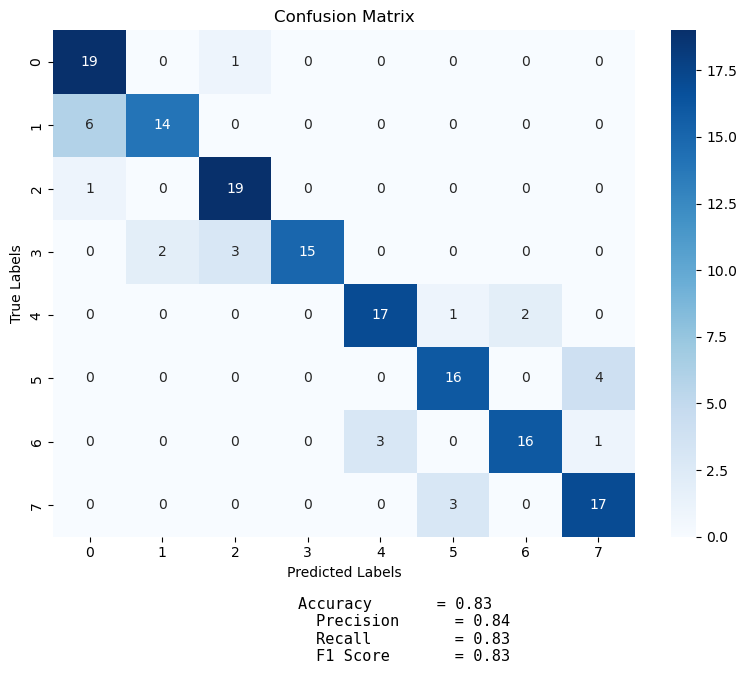

In [32]:
if is_training:    
    df = pd.read_csv("Dataset_2_v1.csv")
    # Calculate confusion matrix and other metrics
    y_true = df.iloc[:, 3]  # True labels
    y_pred = df.iloc[:, 4]  # Predicted labels
    cMat = metrics.confusion_matrix(y_true, y_pred)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, average='macro')  # Macro for multi-class
    recall = metrics.recall_score(y_true, y_pred, average='macro')  # Macro for multi-class
    f1 = metrics.f1_score(y_true, y_pred, average='macro')  # Macro for multi-class

    # Plot using Seaborn with index labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cMat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    metrics_text = f"""
    Accuracy       = {accuracy:.2f}
    Precision      = {precision:.2f}
    Recall         = {recall:.2f}
    F1 Score       = {f1:.2f}
    """

    # Create a text box
    plt.gcf().text(0.5, -0.11, metrics_text.strip(), ha='center', fontsize=11, family='monospace')

    plt.tight_layout()
    plt.show()